## 🧠 Project Title: Psoriasis vs Eczema Image Classifier
### 👨‍⚕️ Goal: Build a Deep Learning model to classify skin diseases (Psoriasis and Eczema) using image data.

In [13]:
# 📘 Image Classification: Psoriasis vs Eczema
# Step 2: Importing Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1


In [14]:
# 🔍 Set dataset paths
base_dir = "SKIN DISEASE IMAGE CLASSIFIER"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Ensure directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 🧮 Function to count images in each class
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        counts[class_name] = len(os.listdir(class_path))
    return counts

# ✅ Count images in train and test folders
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("📊 Number of images in Train Set:", train_counts)
print("📊 Number of images in Test Set:", test_counts)


📊 Number of images in Train Set: {'Eczema': 714, 'Psoriasis': 693}
📊 Number of images in Test Set: {'Eczema': 167, 'Psoriasis': 155}


## Define Dataset Paths
Now define the paths for your folders:

In [15]:
# Dataset directory
base_dir = 'SKIN DISEASE IMAGE CLASSIFIER'

# Training and testing directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Check classes
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['Eczema', 'Psoriasis']
Test classes: ['Eczema', 'Psoriasis']


## Visualize Sample Images


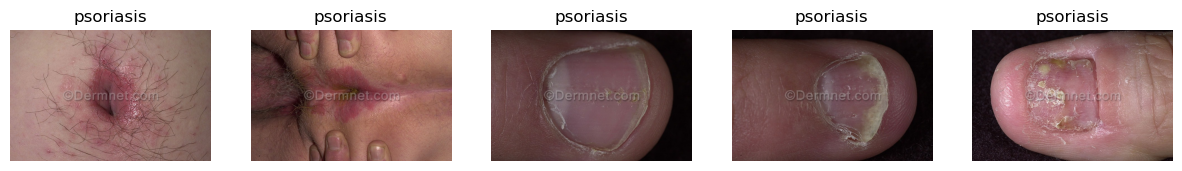

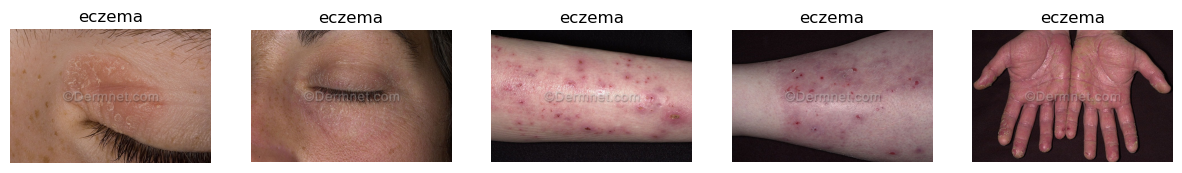

In [16]:
# Function to show sample images
def show_sample_images(class_name, folder='train', num_images=5):
    class_path = os.path.join(base_dir, folder, class_name)
    images = glob(os.path.join(class_path, '*.jpg'))[:num_images]

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Show samples from both classes
show_sample_images('psoriasis')
show_sample_images('eczema')


## Preprocess the images
We’ll use Keras ImageDataGenerator to:

Resize all images to a fixed size (e.g., 224x224)

Normalize pixel values

Apply data augmentation (only for training data)

In [17]:
# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    brightness_range=[0.8,1.2],
    validation_split=0.2
)
# Validation data generator (no augmentation, just rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 1127 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## Build the EfficientNet Model

In [18]:


base_model = EfficientNetB1(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base initially


In [19]:
# Freeze only first few layers instead of the whole base
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [21]:

model.compile(optimizer=Adam(1e-4),  # Higher lr since base is frozen
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [22]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]


In [23]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
36/36 [==============================] - 146s 4s/step - loss: 0.7147 - accuracy: 0.5324 - val_loss: 0.7086 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 2/15
36/36 [==============================] - 133s 4s/step - loss: 0.6802 - accuracy: 0.5821 - val_loss: 0.7097 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 3/15
36/36 [==============================] - 135s 4s/step - loss: 0.6882 - accuracy: 0.5794 - val_loss: 0.6963 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 4/15
36/36 [==============================] - 136s 4s/step - loss: 0.6614 - accuracy: 0.6025 - val_loss: 0.6972 - val_accuracy: 0.4964 - lr: 1.0000e-04
Epoch 5/15
36/36 [==============================] - 142s 4s/step - loss: 0.6678 - accuracy: 0.5812 - val_loss: 0.7027 - val_accuracy: 0.4964 - lr: 1.0000e-04
Epoch 6/15
36/36 [==============================] - 142s 4s/step - loss: 0.6763 - accuracy: 0.5892 - val_loss: 0.6959 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 7/15
36/36 [==============================] - 

In [24]:
train_generator.classes
np.unique(train_generator.classes, return_counts=True)


(array([0, 1]), array([572, 555], dtype=int64))

9/9 [==============================] - 14s 1s/step


<Figure size 600x600 with 0 Axes>

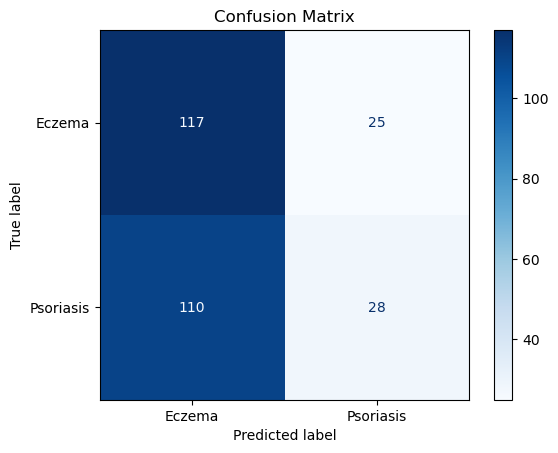

Classification Report:

              precision    recall  f1-score   support

      Eczema       0.52      0.82      0.63       142
   Psoriasis       0.53      0.20      0.29       138

    accuracy                           0.52       280
   macro avg       0.52      0.51      0.46       280
weighted avg       0.52      0.52      0.47       280



In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
val_generator.reset()  # Reset the generator
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Class labels from the generator
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2


In [27]:
img_path = './SKIN DISEASE IMAGE CLASSIFIER/test/Psoriasis/Psoriasis-Chronic-Plaque-123.jpg'  # Replace this with your test image path

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize


In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


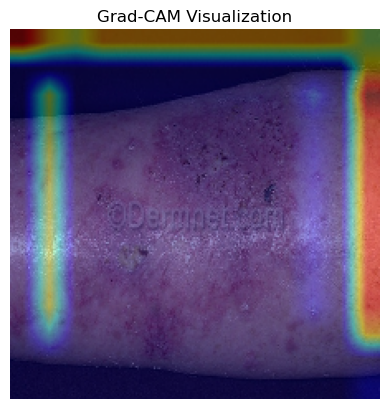

In [38]:
# Convert PIL image to NumPy array
img_array = np.array(img_array) / 255.0  # Normalize pixel values

# Generate heatmap
heatmap = make_gradcam_heatmap(np.expand_dims(img_array, axis=0), model, last_conv_layer_name='block4b_dwconv')

# Overlay heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Show
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './SKIN DISEASE IMAGE CLASSIFIER/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Pick image
img_index = 9
img_path = test_generator.filepaths[img_index]
true_class_index = test_generator.classes[img_index]
class_names = list(test_generator.class_indices.keys())
true_class_name = class_names[true_class_index]

# Load and preprocess image
img_array = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img_array) / 255.0
img_tensor = np.expand_dims(img_tensor, axis=0)

# Predict
preds = model.predict(img_tensor)
predicted_class_index = np.argmax(preds)
predicted_class_name = class_names[predicted_class_index]

# ✅ Automatically get the last Conv2D layer
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

# Grad-CAM model
grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

# Grad-CAM logic
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    loss = predictions[:, predicted_class_index]

# Gradient of the output neuron w.r.t. last conv layer output
grads = tape.gradient(loss, conv_outputs)

# Mean of gradients over the width and height
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each channel in feature map array by "how important it is"
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# ReLU and normalize
heatmap = tf.maximum(heatmap, 0)
max_val = tf.reduce_max(heatmap)
if max_val != 0:
    heatmap /= max_val
heatmap = heatmap.numpy()

# Resize heatmap and superimpose
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title(f"Original\nTrue: {true_class_name}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Prediction: {predicted_class_name}")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [36]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)


0 input_2 [(None, 224, 224, 3)]
1 rescaling_2 (None, 224, 224, 3)
2 normalization_1 (None, 224, 224, 3)
3 rescaling_3 (None, 224, 224, 3)
4 stem_conv_pad (None, 225, 225, 3)
5 stem_conv (None, 112, 112, 32)
6 stem_bn (None, 112, 112, 32)
7 stem_activation (None, 112, 112, 32)
8 block1a_dwconv (None, 112, 112, 32)
9 block1a_bn (None, 112, 112, 32)
10 block1a_activation (None, 112, 112, 32)
11 block1a_se_squeeze (None, 32)
12 block1a_se_reshape (None, 1, 1, 32)
13 block1a_se_reduce (None, 1, 1, 8)
14 block1a_se_expand (None, 1, 1, 32)
15 block1a_se_excite (None, 112, 112, 32)
16 block1a_project_conv (None, 112, 112, 16)
17 block1a_project_bn (None, 112, 112, 16)
18 block1b_dwconv (None, 112, 112, 16)
19 block1b_bn (None, 112, 112, 16)
20 block1b_activation (None, 112, 112, 16)
21 block1b_se_squeeze (None, 16)
22 block1b_se_reshape (None, 1, 1, 16)
23 block1b_se_reduce (None, 1, 1, 4)
24 block1b_se_expand (None, 1, 1, 16)
25 block1b_se_excite (None, 112, 112, 16)
26 block1b_project_conv (